In [218]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#normalization
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#splitting and feature selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold

#model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree


#evaluation
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, recall_score
import shap


#shhhhhh
import warnings
warnings.filterwarnings('ignore')

In [135]:
def soilrm(df):
    df2 = df[df["Classification"] != "soil"]
    soil = df[df["Classification"] == "soil"]
    return df2, soil

In [185]:
#box location for Alex
data_dir = "/Users/alexlukasiewicz/Box Sync/Spring 2023/Sci Machine Learning/Bio Team SDS384/Datasets"

#data import
cog = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/cog_ratios.csv")

#pfam = pd.read_csv(data_dir + "/Levy_2017_datasets/cogs_pfams_tigrfam_ko/pfam_ratios.csv")
 
dbcan = pd.read_csv(data_dir + "/dbcan4_outputs/dbcan_result.3772genomes.matrix.divided_by_gene_counts.tsv", sep="\t")

In [186]:
metadata = pd.read_csv(data_dir + "/jgi_metadata_processed.csv")

In [187]:
#Scale datasets and generate presence/ absence pfam dataframe (0,1)
dbcan = dbcan.rename(columns = {"taxonID" : "2016_taxon_oid"})

#add hgt % to dbcan dataset
dbcan = pd.merge(dbcan, cog[['2016_taxon_oid', 'Horizontally_Transferred_%']], 
                             on='2016_taxon_oid', 
                             how='left')

In [188]:
#remove soil from all three datasets 

cog, soilcog = soilrm(cog)

#pfam, soilfam = soilrm(pfam)

dbcan, soilcan = soilrm(dbcan)

In [189]:
columns = ['Classification', 'Horizontally_Transferred_%', "Gene_Count___*_assembled"]
merged = pd.merge(dbcan, cog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

#x and y variables
variables = merged.columns[:4]
classif = merged['Classification']

scaler = StandardScaler()
dbcan_normalized = pd.DataFrame(scaler.fit_transform(merged.iloc[:,4:]), columns = merged.iloc[:,4:].columns)
dbcan_normalized.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738


In [7]:
#checking for balance of PA:NPA counts
len(dbcan[dbcan['Classification'] == "NPA"])

2117

The data appears to be roughly 65% NPA, and 35% PA. It may be a good idea to stratify the train_test split function here 

In [190]:
#split the dataset, but stratify by classification
X_train, X_test, y_train, y_test = train_test_split(dbcan_normalized,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)

In [9]:
len(X_train.columns)

4561

In [139]:
#feature selection using training dataset
from sklearn.feature_selection import SelectKBest

#evaluating accuracy
from sklearn import metrics

#list of feature k to try
total_feat = len(X_train.columns)
k_list = range(10, total_feat, 100)
neighbors = range(1,11)
accuracy = {"k": [], "n": [], "accuracy": [], "accuracy_train": []}

for kn in k_list:
    # select features 
    selector = SelectKBest(k=kn)
    X_train_selected = selector.fit_transform(X_train,y_train)
    for n in neighbors:
        #fit using KNeighbors
        KNC = KNeighborsClassifier(n_neighbors = n)
        KNC.fit(X_train_selected, y_train)

        # select the same features on the test set, predict, and get the test accuracy:
        X_test_selected = selector.transform(X_test)
        y_pred = KNC.predict(X_test_selected)

        #log accuracy
        accuracy['k'].append(kn)
        accuracy['n'].append(n)
        accuracy['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
        accuracy['accuracy_train'].append(KNC.score(X_train_selected,y_train))

accuracy_dataframe = pd.DataFrame.from_dict(accuracy)

KeyboardInterrupt: 

In [27]:
accuracy_dataframe = pd.DataFrame.from_dict(accuracy)
accuracy_dataframe['diff'] = accuracy_dataframe['accuracy_train'] - accuracy_dataframe['accuracy']
accuracy_dataframe.sort_values(by = "diff", ascending = True)[:100]

,k,n,accuracy,accuracy_train,diff
159,1510,10,0.859796,0.890110,0.030314
168,1610,9,0.857939,0.890568,0.032629
278,2710,9,0.856082,0.890110,0.034028
178,1710,9,0.857010,0.891484,0.034473
169,1610,10,0.853296,0.888278,0.034982
...,...,...,...,...,...
269,2610,10,0.844940,0.890110,0.045170
359,3510,10,0.844011,0.889194,0.045183
399,3910,10,0.843083,0.888278,0.045196
454,4510,5,0.858867,0.904304,0.045437


The value of k and n that minimize the difference in accuracy between the test and training datasets is at k = 1510, and n = 10

In [96]:
#break up with matplotlib
from plotnine import *

g = ggplot(accuracy_dataframe, aes(x='k', y='accuracy', color='n')) + geom_point(stat='identity') + theme_classic() + geom_vline(xintercept = 1510, linetype = "dashed", color = "grey")
g.save("feature_selec_kmeans.png",dpi = 300)

NameError: name 'accuracy_dataframe' is not defined

/var/folders/yf/pl2fqbcj153fvwq1yflkkhcm0000gn/T/ipykernel_48995/3294862785.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(neighbors, accuracy, 'bo-', color='steelblue')


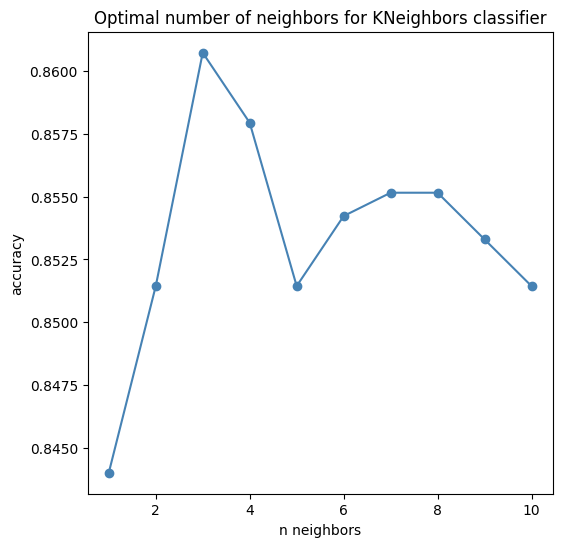

In [27]:
plt.figure(figsize=(6,6))
plt.plot(neighbors, accuracy, 'bo-', color='steelblue')
plt.xlabel('n neighbors')
plt.ylabel('accuracy')
plt.title('Optimal number of neighbors for KNeighbors classifier for dbcan dataset')
plt.show()


In [140]:
#feature select using k = 1510
selector = SelectKBest(k=1510)
X_train_selected = selector.fit_transform(X_train,y_train)
selected_features = dbcan_normalized.columns[selector.get_support()]

#fit using KNeighbors
KNC = KNeighborsClassifier(n_neighbors = 10)
KNC.fit(X_train_selected, y_train)

# select the same features on the test set, predict, and get the test accuracy:
X_test_selected = selector.transform(X_test)
y_pred = KNC.predict(X_test_selected)

    
#log accuracy
print("KNeighbors Accuracy Score for dbcan annotations is " + str(metrics.accuracy_score(y_test, y_pred)))

KNeighbors Accuracy Score for dbcan annotations is 0.8597957288765088


In [35]:
#export feature list
import pickle as pkl

filename = 'Kbest_features.pickle'

with open(filename, 'wb') as file:
    pkl.dump(selected_features, file)


What if we merge the COG percentages with the dbcan annotations?

In [73]:
columns = ['Classification', 'Horizontally_Transferred_%', "Gene_Count___*_assembled"]
merged = pd.merge(dbcan, cog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

merged.head()

,2016_taxon_oid,Order,Classification,Root_info,AA1,AA10,AA12,AA3,AA4,AA5,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,2511231155,Acinetobacter,NPA,NPA,0.000252,0.0,0.000000,0.000252,0.000252,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2519103115,Acinetobacter,NPA,NPA,0.000265,0.0,0.000265,0.000265,0.000265,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2519899735,Acinetobacter,NPA,NPA,0.000262,0.0,0.000262,0.000262,0.000262,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2526164562,Acinetobacter,NPA,NPA,0.000495,0.0,0.000000,0.000248,0.000248,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529293005,Acinetobacter,NPA,NPA,0.000263,0.0,0.000263,0.000263,0.000263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
#generate the variables and noramlize again
variables = merged.columns[:4]
classif = merged['Classification']

scaler = StandardScaler()
merged_norm = pd.DataFrame(scaler.fit_transform(merged.iloc[:,4:]), columns = merged.iloc[:,4:].columns)
merged_norm.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.066808,-0.378513,-0.423784,-0.389091,1.002863,-0.170719,2.537982,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
1,0.136692,-0.378513,2.474260,-0.348927,1.096538,-0.170719,1.528209,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
2,0.121340,-0.378513,2.441586,-0.357750,1.075959,-0.170719,2.681372,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
3,1.317699,-0.378513,-0.423784,-0.400855,0.975425,-0.170719,2.484157,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738
4,0.123815,-0.378513,2.446855,-0.356327,1.079278,-0.170719,2.687882,-0.644416,-0.115373,-0.150815,...,-0.406102,-0.578561,-0.105001,-0.268621,-0.087445,-0.404687,-0.304982,-0.76716,-0.229263,-0.271738


In [75]:
#split the dataset, but stratify by classification
X_train, X_test, y_train, y_test = train_test_split(merged_norm,
                                                    classif, test_size=0.33,
                                                    random_state=42, 
                                                    stratify=classif)


In [31]:
#how does this normalized dataset perform compared to random forest? from Muyoung script
clf2 = RandomForestClassifier(max_depth=10, random_state=42)
clf2.fit(X_train_labeled, y_train)

# select the same features on the test set, predict, and get the test accuracy:
X_test_selected = selector.transform(X_test)
y_pred = clf2.predict(X_test_selected)

importances = clf2.feature_importances_
forest_importances = pd.Series(importances, index=clf2.feature_names_in_)
forest_importances.sort_values(ascending=False)[:10]

COG0798       0.012722
Unnamed: 0    0.012172
COG1349       0.011319
COG1129       0.010252
COG0837       0.010021
COG4213       0.009540
COG3175       0.009527
COG1879       0.009237
COG0667       0.008860
COG0467       0.008544
dtype: float64

Hooray! The top 3 COGs are all genes that encode for carbohydrate metabolising enzymes:

https://www.ncbi.nlm.nih.gov/research/cog/cog/COG3386/#

https://www.ncbi.nlm.nih.gov/Structure/cdd/COG1129

https://www.ncbi.nlm.nih.gov/research/cog/cog/COG0837/#

In [212]:
soil_dataset = pd.merge(soilcan, soilcog.drop(columns, axis = 1), on='2016_taxon_oid', how='left')

scaler = StandardScaler()
soil_norm = pd.DataFrame(scaler.fit_transform(soil_dataset.iloc[:,4:]), columns = soil_dataset.iloc[:,4:].columns)
soil_norm.head()

,AA1,AA10,AA12,AA3,AA4,AA5,AA6,AA7,CBM11,CBM12,...,COG5653,COG5654,COG5655,COG5658,COG5659,COG5660,COG5661,COG5662,COG5663,COG5664
0,0.462913,-0.625204,-0.319784,-0.077318,0.686879,-0.189468,4.144194,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
1,0.410020,-0.625204,-0.319784,-0.103413,0.620996,-0.189468,2.386069,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
2,1.727213,-0.625204,3.009467,-0.127694,0.559694,-0.189468,2.276146,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
3,0.382872,-0.625204,-0.319784,0.568221,0.587180,-0.189468,3.876035,-0.810045,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197
4,-0.300240,2.223318,-0.319784,-0.105831,-0.263711,2.117036,-0.775772,0.239899,-0.143771,-0.210686,...,-0.370132,-0.351246,-0.143073,-0.606353,-0.257713,-0.119156,-0.209364,-0.692661,-0.429728,-0.13197


In [214]:
X_soil = soil_norm[union_features]
X_train = X_train[union_features]

LR = LogisticRegression(max_iter = 500, penalty = 'l1', solver = 'saga')
LR.fit(X_train, y_train)

LRPredict = LR.predict(X_soil)

In [220]:
#soil_dataset['RFpred'] = RFpredict
#soil_dataset['KNeighbors'] = KNpredict
soil_dataset['LRPredict'] = LRPredict

In [241]:
counts = soil_dataset.groupby(['Order','LRPredict']).size().reset_index(name = 'count')

#desired_order = ["Firmicutes", "Actinobacteria", "Proteobacteria","Bacteroidetes"]

#counts["IMG_Phylum"] = pd.Categorical(counts["IMG_Phylum"], categories=desired_order, ordered=True)


# create a stacked barplot using plotnine
order_counts = ggplot(counts, aes(x='Order', y='count', fill='LRPredict')) + \
    geom_bar(stat='identity') + \
    labs(x = 'Order', y='Count', fill='Classification') + \
    ggtitle('Classification of soil dataset')+ \
    coord_flip() + \
    scale_fill_manual(values = color_values) + \
    theme_classic()

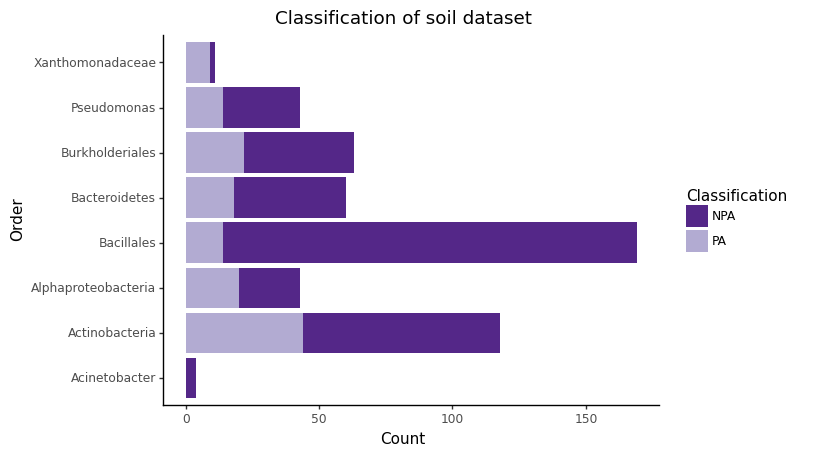

<ggplot: (331086800)>

In [242]:
order_counts

In [85]:
#how often do they match?
num_matches = sum(soil_dataset['RFpred'] == soil_dataset['KNeighbors'])

print("random forest and KNeighbors have " +
      str(num_matches) + 
      " matching predictions and " +
      str(511 - num_matches) + " that do not match")

random forest and KNeighbors have 440 matching predictions and 71 that do not match


In [191]:
#feature selection from overlap

union_features = pd.read_csv("overlapping_features.csv")
union_features = union_features['elements'].values

In [192]:
X = dbcan_normalized[union_features]
X_train = X_train[union_features]
X_test = X_test[union_features]

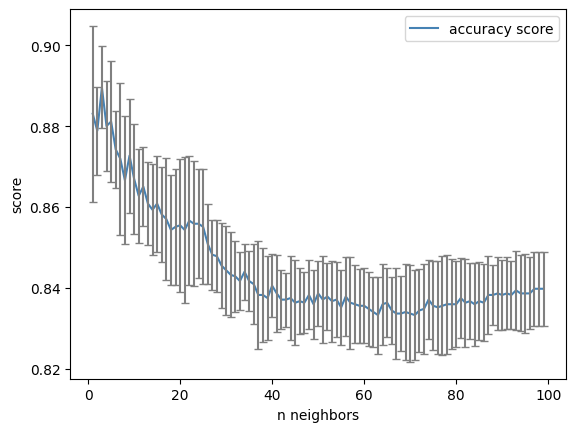

In [206]:
#find minimum variance using k fold cross validation

#list of feature k to try
neighbors = range(1,100)
accuracy = {"n": [], "accuracy": [], "std": []}

skf = StratifiedKFold(n_splits=5, shuffle= True, random_state= 17)

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    
    #calculate cross val scores
    val_scores = cross_val_score(estimator= KNC,  X= X_train, y= y_train, cv= skf)

    #log accuracy
    accuracy['n'].append(n)
    accuracy['accuracy'].append(val_scores.mean())
    accuracy['std'].append(val_scores.std())

accuracy_dataframe = pd.DataFrame.from_dict(accuracy)

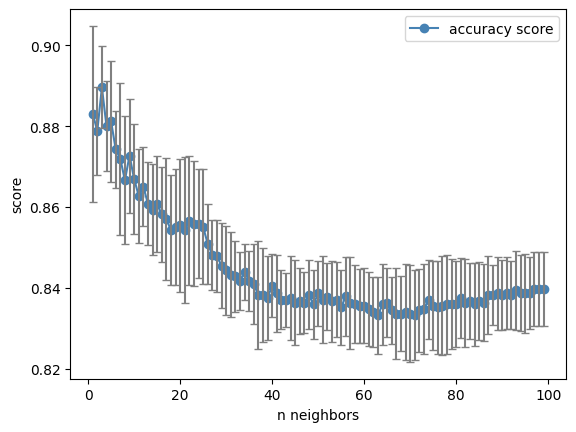

In [214]:
#plot dataframe 
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['accuracy'],'o-', label='accuracy score', color = 'steelblue')
plt.errorbar(accuracy_dataframe['n'], accuracy_dataframe['accuracy'], yerr=accuracy_dataframe['std'], fmt='none', color='gray', capsize=3)

# add a title and labels to the plot
plt.xlabel('n neighbors')
plt.ylabel('score')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

In [216]:
accuracy_dataframe.sort_values(by = ["accuracy",'std'], ascending = [False,True])[:20]

,n,accuracy,std
2,3,0.889615,0.010154
0,1,0.883108,0.021731
4,5,0.881187,0.014893
3,4,0.880038,0.011146
1,2,0.878887,0.010867
5,6,0.874285,0.009537
8,9,0.872751,0.014088
6,7,0.871987,0.018794
9,10,0.867002,0.013549
7,8,0.866623,0.015821


In [195]:
#list of feature k to try
neighbors = range(1,100)
accuracy = {"n": [], "accuracy": [], "overfit": []}

for n in neighbors:
    #fit using KNeighbors
    KNC = KNeighborsClassifier(n_neighbors = n)
    KNC.fit(X_train, y_train)

    # select the same features on the test set, predict, and get the test accuracy:
    y_pred = KNC.predict(X_test)

    #log accuracy
    accuracy['n'].append(n)
    accuracy['accuracy'].append(metrics.accuracy_score(y_test, y_pred))
    accuracy['overfit'].append(KNC.score(X_train, y_train))

accuracy_dataframe = pd.DataFrame.from_dict(accuracy)
accuracy_dataframe['diff'] = accuracy_dataframe['overfit'] - accuracy_dataframe['accuracy']
accuracy_dataframe.sort_values(by = "diff", ascending = True)[:100]

,n,accuracy,overfit,diff
22,23,0.854225,0.869963,0.015739
20,21,0.857939,0.875458,0.017519
15,16,0.859796,0.881410,0.021615
23,24,0.845868,0.868132,0.022264
74,75,0.826370,0.848901,0.022532
...,...,...,...,...
4,5,0.864438,0.924451,0.060012
3,4,0.865367,0.932234,0.066868
2,3,0.873723,0.944597,0.070874
1,2,0.873723,0.957875,0.084152


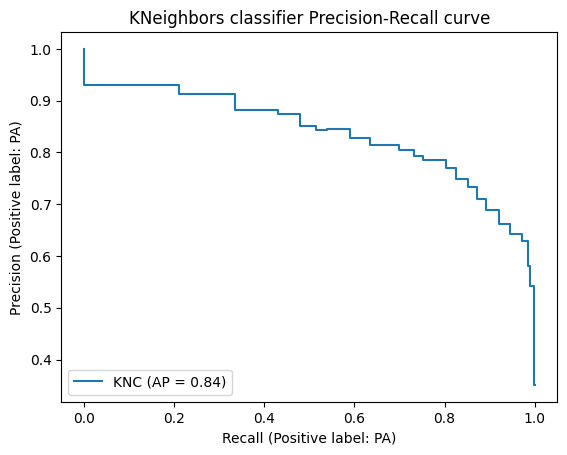

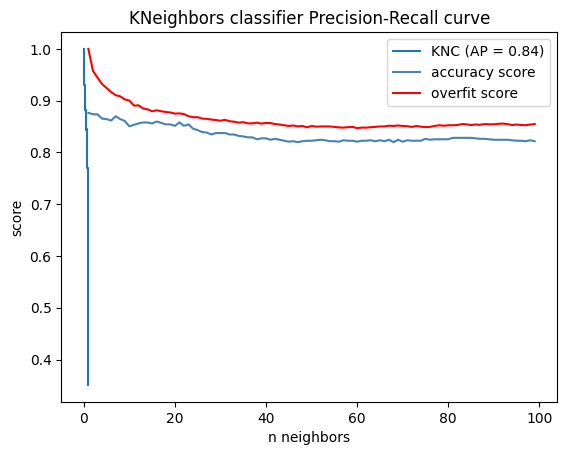

In [202]:
#plot dataframe 
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['accuracy'], label='accuracy score', color = 'steelblue')
plt.plot(accuracy_dataframe['n'], accuracy_dataframe['overfit'], label='overfit score', color = 'red')

# add a title and labels to the plot
plt.xlabel('n neighbors')
plt.ylabel('score')

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

In [219]:
#train using best n that minimizes overfit score, n = 23
KNC = KNeighborsClassifier(n_neighbors = 3)
KNC.fit(X_train, y_train)

# select the same features on the test set, predict, and get the test accuracy:
y_pred = KNC.predict(X_test)
    
#report accuracy
(metrics.accuracy_score(y_test, y_pred))


0.897239263803681

In [222]:
# Initialize a kmeans clustering object with 5 clusters
kmeans = shap.kmeans(X_train, 5)

# Use SHAP to calculate feature importance
explainer = shap.KernelExplainer(KNC.predict_proba, kmeans)
shap_values = explainer.shap_values(X_test)

# Get the top 10 features based on their SHAP values
top_10 = shap.approximate_interactions(shap_values, X_test).sum(axis=0).argsort()[-10:]

# Print the names of the top 10 features
feature_names = X.feature_names
print("Top 10 features:")
for feature_idx in top_10:
    print(feature_names[feature_idx])

100%|█████████████████████████████████████████| 652/652 [33:40<00:00,  3.10s/it]


TypeError: approximate_interactions() missing 2 required positional arguments: 'shap_values' and 'X'

In [225]:
shap.plots.scatter(shap_values[:,"COG0667"], color=shap_values[:,"COG0667"])

TypeError: list indices must be integers or slices, not tuple

In [199]:
# Load data and target variables
X = dbcan_normalized[union_features].values
y = classif.values

#evaluation dict 
cross_val = {"model" : [],
             "accuracy": [], 
             "accuracy_std": [], 
             "precision": [], 
             "precision_std": [], 
             "recall" : [], 
             "recall_std": [],
             "f1" : [],
             "f1_std": [],}

# Create a KFold object with k=5
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize a dictionary to store the models; parameters provided by Sarah and Muyoung for their models
models = {
    'KNeighbors': KNeighborsClassifier(n_neighbors=10),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth = 12),
    'LogisticRegression': LogisticRegression(max_iter = 500, penalty = 'l1', solver = 'saga'),
    'DecisionTree': DecisionTreeClassifier(max_depth = 12)
}

# Loop through each model and perform cross-validation
for name, model in models.items():
    accuracies = []
    precision = []
    recall = []
    f1 = []
    roc_auc = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Predict the labels of the test data
        y_pred = model.predict(X_test)

        # Compute the accuracy score and append it to the list
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
        
        #calculate and print the precision
        precision.append(precision_score(y_test, y_pred, pos_label = "PA"))

        # calculate and print the recall
        recall.append(recall_score(y_test, y_pred, pos_label = "PA"))

        # calculate and print the F1 score
        f1_sc = f1_score(y_test, y_pred, pos_label = 'PA')
        f1.append(f1_sc)

    # Compute the mean and standard deviation of the accuracies
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    cross_val["model"].append(name)
    cross_val["accuracy"].append(mean_accuracy)
    cross_val["accuracy_std"].append(std_accuracy)
    cross_val["precision"].append(np.mean(precision)) 
    cross_val["precision_std"].append(np.std(precision)) 
    cross_val["recall"].append(np.mean(recall))
    cross_val["recall_std"].append(np.std(recall))
    cross_val["f1"].append(np.mean(f1))
    cross_val["f1_std"].append(np.std(f1))

    # Print the results
    #print(f'{name}: mean accuracy={mean_accuracy:.2f}, std={std_accuracy:.2f}')
    #print(f'{name}: mean precision={np.mean(precision):.2f}, std={np.std(precision):.2f}')
    #print(f'{name}: mean recall={np.mean(recall):.2f}, std={np.std(recall):.2f}')
    #print(f'{name}: mean f1={np.mean(f1):.2f}, std={np.std(f1):.2f}')
    #print(f'{name}: mean roc_auc={np.mean(roc_auc):.2f}, std={np.std(roc_auc):.2f}')


In [200]:
cross_val = pd.DataFrame.from_dict(cross_val)

In [201]:
cross_val

,model,accuracy,accuracy_std,precision,precision_std,recall,recall_std,f1,f1_std
0,KNeighbors,0.881643,0.020753,0.825375,0.046913,0.839105,0.026694,0.831866,0.034786
1,RandomForest,0.900035,0.011652,0.858251,0.029295,0.855268,0.013260,0.856668,0.021002
2,LogisticRegression,0.909846,0.010488,0.864800,0.026830,0.880510,0.016522,0.872341,0.016982
3,DecisionTree,0.847590,0.006963,0.778299,0.017346,0.791856,0.030281,0.784427,0.011476


In [198]:
cross_val.to_csv('cross_validation_union.csv')

In [223]:
#get top features from union LR 
X = dbcan_normalized[union_features]
X_train = X_train[union_features]
X_test = X_test[union_features]

LR = LogisticRegression(max_iter = 5000, penalty = 'l1', solver = 'saga')
LR.fit(X_train, y_train)

LRPredict = LR.predict_proba(X_test)


In [228]:
LR_co = abs(LR.coef_[0])

#union_features.reset_index(drop=True, inplace=True)

LR_coeff = pd.concat([pd.DataFrame(union_features), pd.DataFrame(LR_co)], axis = 1)
LR_coeff.index = union_features
LR_coeff.columns = 'Features', 'Coefficents'

LR_coeff.nlargest(100, 'Coefficents')['Coefficents']

LR_coeff.to_csv("important_features_for_logistic_regression_model.csv")

In [131]:
#Visualizing the data using plotnine 
counts = metadata['Classification'].value_counts().reset_index()
counts.columns = ['class','count']

color_values = ['#542788', '#b2abd2','#fdae61']

bar = ggplot(counts, aes(x = 'class', y = 'count', fill = 'class')) + geom_bar(stat = 'identity', color = 'grey') + geom_text(aes(label='count'), va='bottom')
bar = bar + theme_classic() + scale_fill_manual(values = color_values) + labs(title='counts of genome classes', x='association', y='count')
bar.save('counts_classes_in_dataset.png', dpi = 300)


In [144]:
sorted_metadata = metadata.sort_values(by = "Gene_Count___*_assembled", ascending = True)
sorted_metadata['position'] = range(1, len(sorted_metadata) + 1)

# get the frequency of each size
size_counts = metadata['Gene_Count___*_assembled'].value_counts()

genomes = (ggplot(metadata, aes(x='Gene_Count___*_assembled'))
 + geom_histogram(bins=len(size_counts), fill='#6baed6', color='lightblue')
 + labs(x='Genome Sizes', y='Frequency', title='Distribution of genome sizes')
 + theme_classic()
 + ylim(0, 25)
)

genomes.save("genome_size_distribution.png", dpi = 300)

In [82]:
sorted_metadata = metadata.sort_values(by = "Gene_Count___*_assembled", ascending = False)
sorted_metadata["Gene_Count___*_assembled"]

3444    10951.0
1420    10896.0
1393    10841.0
1378    10596.0
1376    10577.0
         ...   
3808        NaN
3809        NaN
3814        NaN
3817        NaN
3824        NaN
Name: Gene_Count___*_assembled, Length: 3837, dtype: float64

In [244]:
counts = metadata.groupby(['Taxonomic_Group','Classification']).size().reset_index(name = 'count')

#desired_order = ["Firmicutes", "Actinobacteria", "Proteobacteria","Bacteroidetes"]

#counts["IMG_Phylum"] = pd.Categorical(counts["IMG_Phylum"], categories=desired_order, ordered=True)


# create a stacked barplot using plotnine
phylo_counts = ggplot(counts[counts['Classification'] != "soil"], aes(x='Taxonomic_Group', y='count', fill='Classification')) + \
    geom_bar(stat='identity') + \
    labs(x = 'Taxon', y='Count', fill='Classification') + \
    ggtitle('Phylogenetic distribution of PA and NPA bacteria')+ \
    coord_flip() + \
    scale_fill_manual(values = color_values) + \
    theme_classic()

phylo_counts
phylo_counts.save("phylogenetic_classification_counts.png", dpi = 300)

In [249]:
counts = metadata.groupby(['Taxonomic_Group','Classification']).size().reset_index(name = 'count')

counts.to_csv("taxonomic_classification_counts.csv")

In [183]:
import seaborn as sns

#heatmap for dbcan data 
dbcan_l2fc['l2fc'] = dbcan.group_by(["IMG_Phyla","Classification"])["value"].mean().reset_index()

control_mean = subset[subset["condition"] == "control"]["value"].mean()
subset["l2fc"] = np.log2(subset["value"] / control_mean)

# Pivot the data to create a matrix of l2fc values
matrix = subset.pivot(index="condition", columns="replicate", values="l2fc")

# Generate the heatmap using Seaborn
sns.heatmap(matrix, cmap="coolwarm", annot=True, fmt=".2f", cbar_kws={"label": "l2fc"})

# Add labels and title
plt.xlabel("Replicate")
plt.ylabel("Condition")
plt.title(f"Heatmap of l2fc for {gene} in {species}")

# Show the plot
plt.show()

3261

In [211]:
#add hgt % to dbcan dataset
dbcan = pd.merge(dbcan, metadata[['2016_taxon_oid', 'IMG_Phylum']], 
                             on='2016_taxon_oid', 
                             how='left')

dbcan_l2fc['l2fc'] = dbcan.groupby(["IMG_Phylum","Classification"])["value"].mean().reset_index()


KeyError: 'Column not found: value'

In [218]:
dbcan.shape

(3261, 354)

In [5]:
family_key = pd.read_csv("counts_classes_in_dataset.csv")

family_key

,COG ID,Category Identifier Letter,Category
0,COG0430,A,RNA processing and modification
1,COG1949,A,RNA processing and modification
2,COG4085,A,RNA processing and modification
3,COG5180,A,RNA processing and modification
4,COG5186,A,RNA processing and modification
...,...,...,...
4916,COG5659,X,"Mobilome: prophages, transposons"
4917,COG1664,Z,Cytoskeleton
4918,COG5019,Z,Cytoskeleton
4919,COG5184,Z,Cytoskeleton


In [14]:
union_features

all_cog = cog.iloc[:,4:4213].columns

In [120]:
union_cog_fams = pd.DataFrame({'union_families': union_features})

union_mapped = pd.merge(union_cog_fams, family_key, how='inner', right_on='COG ID', left_on='union_families')

#union_mapped.drop(columns=[''], inplace=True)

union_mapped.columns

Index(['union_families', 'COG ID', 'Category Identifier Letter', 'Category '], dtype='object')

In [123]:
summary = union_mapped['Category '].value_counts()

summary_counts_cog = summary.reset_index().rename(columns={'index': 'Value', 'Category ': 'cog_count'})

summary = family_key['Category '].value_counts()

summary_counts_all = summary.reset_index().rename(columns={'index': 'Value', 'Category ': 'all_count'})



In [124]:
summary_counts1 = pd.merge(summary_counts_cog, summary_counts_all, how='inner', on='Value')

In [125]:
from scipy.stats import hypergeom

families = summary_counts1['Value']
#counts = summary_counts1['cog_count', 'all_count']
probabilities = {'family': [], 'PMF': []}

for index, row in summary_counts1.iterrows():
    # population size
    N = summary_counts1['all_count'].sum()

    # number of successes in population
    K = row['all_count']

    # sample size
    n = summary_counts1['cog_count'].sum()

    # number of successes in sample
    k = row['cog_count']
    
    # calculate probability of observing k successes in n draws
    prob = hypergeom.pmf(k, N, K, n)
    probabilities['family'].append(row['Value'])
    probabilities['PMF'].append(prob)

prob_df = pd.DataFrame.from_dict(probabilities)

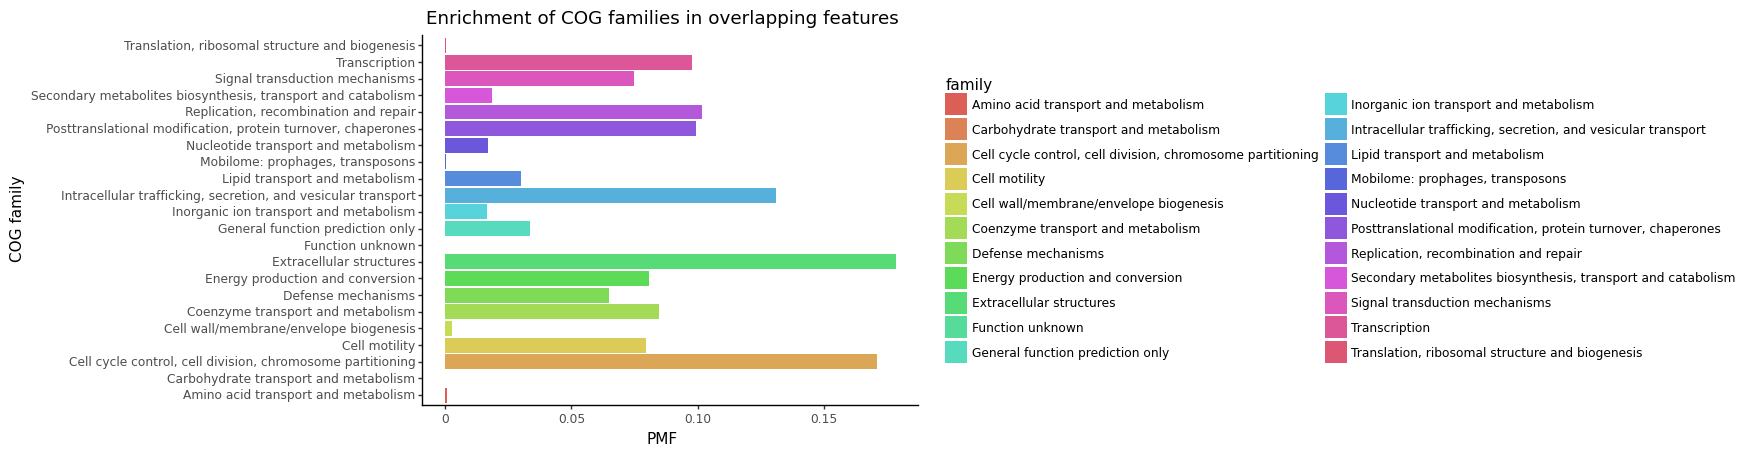

<ggplot: (319592881)>

In [126]:
prob_df


# create a stacked barplot using plotnine
ggplot(prob_df, aes(x='family', y='PMF', fill='family')) + \
    geom_bar(stat='identity') + \
    labs(x = 'COG family', y='PMF') + \
    ggtitle('Enrichment of COG families in overlapping features')+ \
    coord_flip() +\
    theme_classic()

In [113]:
#do the enrichment plots stay the same across the feature selection methods?

RFC = pd.read_csv('Muyoung_853_features.txt', sep=" ", header=None)
Kbest = pd.read_csv('Kbest_features.txt', sep=" ", header=None)
logit = pd.read_csv('logistic_regression_features.txt', sep=" ", header=None, encoding='utf-16')

In [151]:
selected_features = selected_features.to_frame(index = False)

In [228]:
#list of each list of features
feature_selectors = {'random forest': RFC, 
                     'KBest': selected_features,
                     'logistic regression': logit}

probabilities = {'family': [], 'PMF': [], 'selector': [], '% features cog': []}


for name, selector in feature_selectors.items():
    summary_counts = pd.DataFrame()
    
    cog_merge= pd.merge(selector, family_key, how='inner', right_on='COG ID', left_on=0)
    
    summary = cog_merge['Category '].value_counts()

    summary_counts_cog = summary.reset_index().rename(columns={'index': 'Value', 'Category ': 'cog_count'})

    summary = family_key['Category '].value_counts()

    summary_counts_all = summary.reset_index().rename(columns={'index': 'Value', 'Category ': 'all_count'})
    
    summary_counts = pd.merge(summary_counts_cog, summary_counts_all, how='inner', on='Value')

    for index, row in summary_counts.iterrows():
        # population size
        N = summary_counts1['all_count'].sum()

        # number of successes in population
        K = row['all_count']

        # sample size
        n = summary_counts1['cog_count'].sum()

        # number of successes in sample
        k = row['cog_count']

        # calculate probability of observing k successes in n draws
        prob = hypergeom.pmf(k, N, K, n)
        probabilities['family'].append(row['Value'])
        probabilities['PMF'].append(prob)
        probabilities['selector'].append(name)
        probabilities['% features cog'].append(n/len(selector))


prob_df = pd.DataFrame.from_dict(probabilities)
prob_df

,family,PMF,selector,% features cog
0,General function prediction only,1.659225e-10,random forest,0.542790
1,Amino acid transport and metabolism,3.138593e-32,random forest,0.542790
2,Function unknown,9.657140e-03,random forest,0.542790
3,Inorganic ion transport and metabolism,1.230892e-21,random forest,0.542790
4,Carbohydrate transport and metabolism,2.694196e-13,random forest,0.542790
...,...,...,...,...
65,"Intracellular trafficking, secretion, and vesi...",2.215195e-02,logistic regression,1.479233
66,Nucleotide transport and metabolism,7.087610e-03,logistic regression,1.479233
67,Extracellular structures,2.360284e-01,logistic regression,1.479233
68,"Cell cycle control, cell division, chromosome ...",9.098937e-02,logistic regression,1.479233


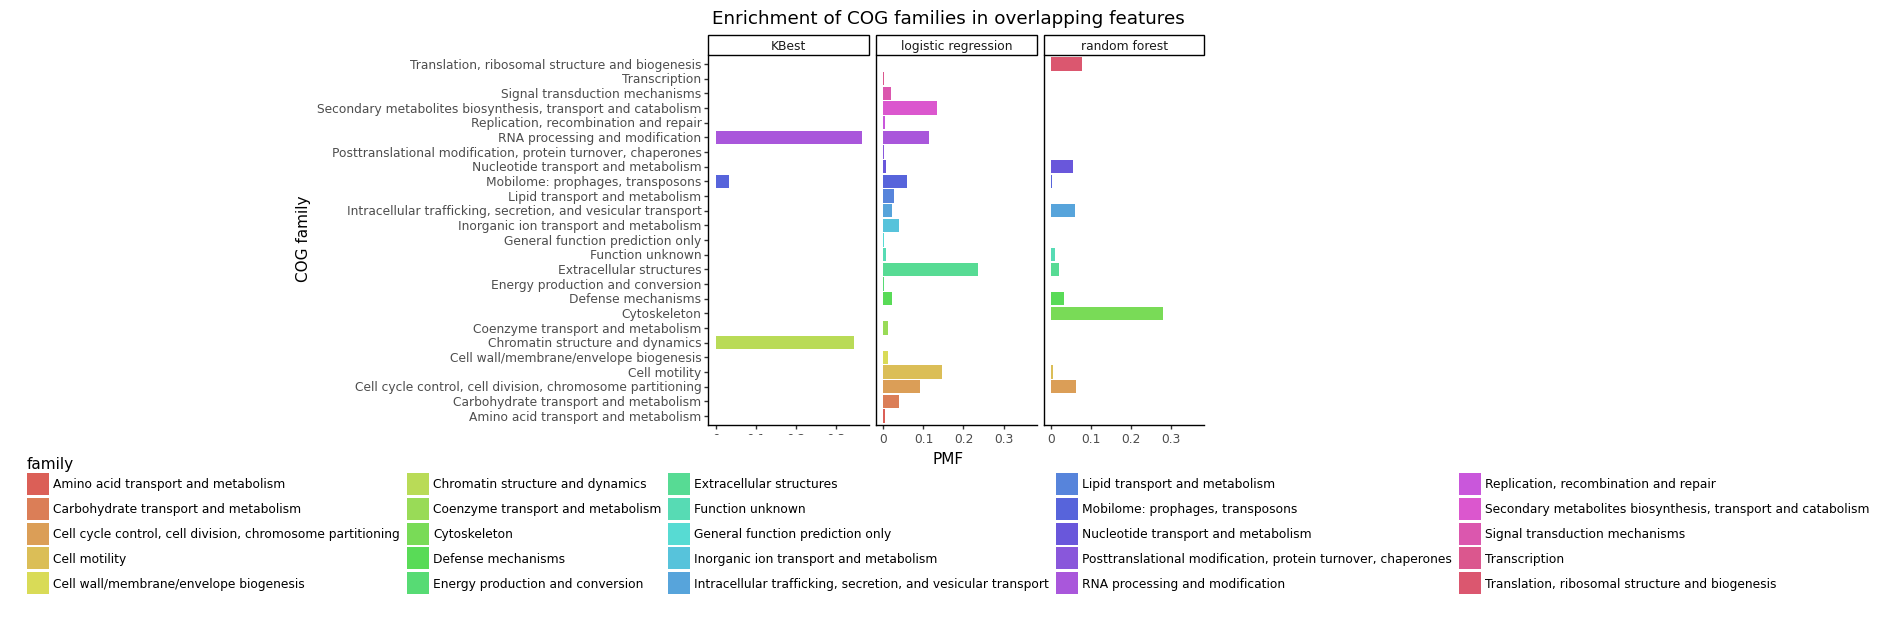

<ggplot: (347969011)>

In [230]:
# create a stacked barplot using plotnine
enrichment = ggplot(prob_df, aes(x='family', y='PMF', fill='family')) + \
    geom_bar(stat='identity') + \
    labs(x = 'COG family', y='PMF') + \
    ggtitle('Enrichment of COG families in overlapping features')+ \
    coord_flip() +\
    facet_wrap("~selector") +\
    theme_classic() +\
    theme(legend_position='bottom')

enrichment